<a href="https://colab.research.google.com/github/sreent/dense-neural-networks/blob/main/codes/Imagenette%20-%20TFDS%20Color%20Image%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Defining the problem and assembling a dataset

- Tensorflow Imagenette Dataset
  - https://www.tensorflow.org/datasets/catalog/imagenette
- Multi-Class Classification Problem

 ## Choosing a measure of success

- Accuracy Score
- F1 Score
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation and test sets
- Doing K-fold cross-validation

## Preparing your data

In [7]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import F1Score, AUC
from keras.utils import to_categorical

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATASET = 'imagenette/160px'
RESIZE = (64, 64, 3)
GRAY_SCALE = True

In [3]:
ds = tfds.load(DATASET, split='all', shuffle_files=True)

images, labels = [], []
for entry in ds.take(len(ds)) :
    image, label = entry['image'], entry['label']

    image, label = image.numpy(), label.numpy()

    image = resize(image, RESIZE, anti_aliasing=True)

    if GRAY_SCALE :
        image = rgb2gray(image)

    images.append( image )
    labels.append( label )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12894 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/160px/1.0.0.incompleteJY4Y14/imagenette-train.tfrecord*...:   0…

Generating validation examples...:   0%|          | 0/500 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/160px/1.0.0.incompleteJY4Y14/imagenette-validation.tfrecord*...…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/160px/1.0.0. Subsequent calls will reuse this data.


In [4]:
# list of images to numpy array
X = np.array(images)

# flatten 2D image array to 1D array
X = X.reshape( (X.shape[0], -1) )

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# label -> one-hot encoded vector
y = to_categorical(label_encoder.transform(labels))

In [9]:
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=labels,
                                                    random_state=SEED, shuffle=True)

In [10]:
# normalise pixels from [0, 255] to [0, 1]
X_train, X_test = X_train/255, X_test/255

In [11]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=VALIDATION_SIZE, stratify=y_train.argmax(axis=1),
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [12]:
# number of samples per each class
counts = np.sum(y, axis=0)

# the dataset is balanced. one class is slightly less than the others, but minimal.
counts

array([1350., 1350., 1350., 1244., 1350., 1350., 1350., 1350., 1350.,
       1350.], dtype=float32)

In [31]:
naive_baseline = max(counts) / sum(counts)

naive_baseline

0.10079139913394057

In [14]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy',
           F1Score(name='f1_score', average='macro'),
           AUC(name='auc', multi_label=True)]

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [ ]:
baseline = Sequential(
    [
        Dense(OUTPUT_CLASSES, activation='softmax', input_shape=(INPUT_DIMENSION,))
    ],
    name="baseline"
)

baseline.summary()

In [ ]:
learning_rate = 0.01
batch_size = 64

EPOCHS = 200

In [ ]:
baseline.compile(optimizer=RMSprop(learning_rate=learning_rate),
                 loss=LOSS_FUNC, metrics=METRICS)

In [35]:
baseline_history = baseline.fit(X_train, y_train,
                                batch_size=batch_size, epochs=EPOCHS,
                                validation_data=(X_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

In [36]:
baseline_scores = baseline.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baseline_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(baseline_scores[1]))
print('AUC (Validation): {:.2f}'.format(baseline_scores[2]))

Accuracy (Validation): 0.31 (Naive Baseline=0.10)
F1 Score (Validation): 0.29
AUC (Validation): 0.74


In [38]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

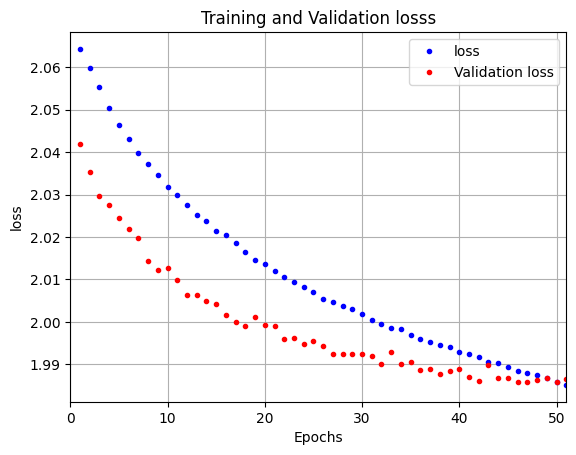

In [39]:
plot_training_history(baseline_history, monitor='loss')

 ## Scaling up: developing a model that overfits

In [47]:
overfit = Sequential(
    [
        Dense(64, activation="relu", input_shape=(INPUT_DIMENSION,), name="hidden"),
        Dense(OUTPUT_CLASSES, activation="softmax", name="output")
    ],
    name="overfit"
)

overfit.summary()

Model: "overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 64)                262208    
                                                                 
 output (Dense)              (None, 10)                650       
                                                                 
Total params: 262858 (1.00 MB)
Trainable params: 262858 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
learning_rate = 0.01

overfit.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=LOSS_FUNC, metrics=METRICS)

In [49]:
EPOCHS = 100
batch_size=64

overfit_history = overfit.fit(X_train, y_train,
                              batch_size=batch_size, epochs=EPOCHS,
                              validation_data=(X_val, y_val),
                              callbacks=[],
                              verbose=0)

In [50]:
overfit_scores = overfit.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(overfit_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(overfit_scores[1]))
print('AUC (Validation): {:.2f}'.format(overfit_scores[2]))

Accuracy (Validation): 0.32 (Naive Baseline = 0.10)
F1 Score (Validation): 0.30
AUC (Validation): 0.74


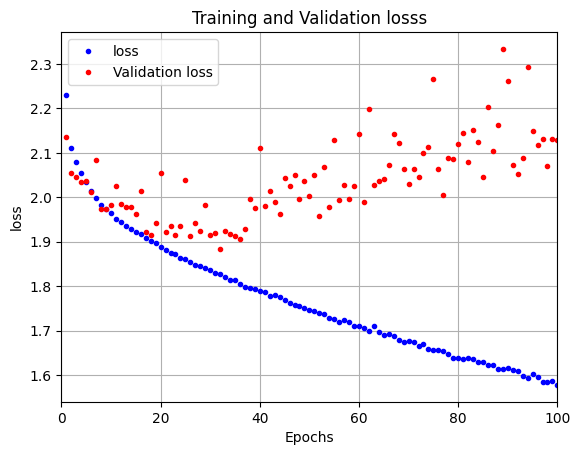

In [51]:
plot_training_history(overfit_history, monitor='loss')